In [1]:
from google.colab import files
uploaded = files.upload()

Saving stack_overflow_16k.tar.gz to stack_overflow_16k.tar.gz


/tmp/ipython-input-1513683911.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5670 - loss: 1.1717 - val_accuracy: 0.8263 - val_loss: 0.5788
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7923 - loss: 0.6114 - val_accuracy: 0.8456 - val_loss: 0.4537
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8146 - loss: 0.5147 - val_accuracy: 0.8462 - val_loss: 0.4176
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8275 - loss: 0.4787 - val_accuracy: 0.8425 - val_loss: 0.4036
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8462 - loss: 0.4382 - val_accuracy: 0.8425 - val_loss: 0.4026
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8435 - loss: 0.4328 - val_accuracy: 0.8506 - val_loss: 0.3947
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8456 - loss: 0.4292 

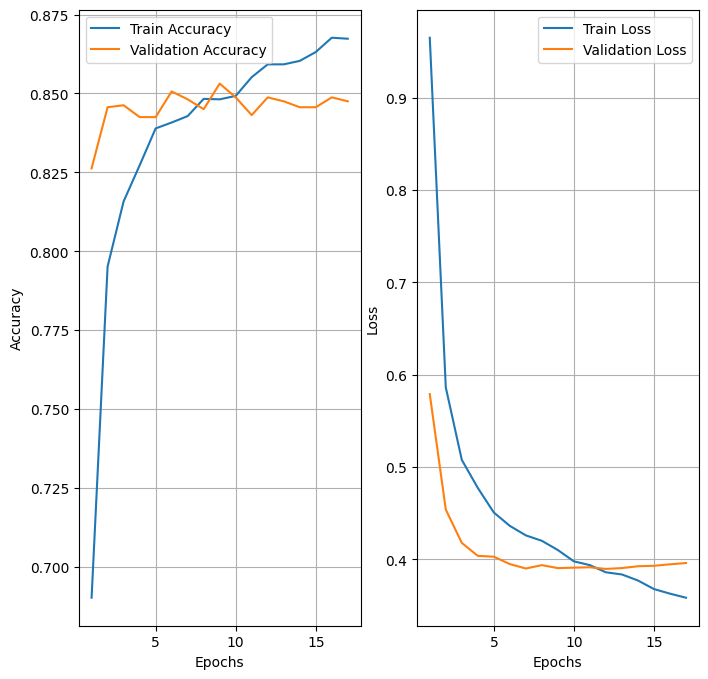

In [12]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tarfile
import pathlib
import tensorflow_hub as hub
import numpy as np

local_tar_path = "stack_overflow_16k.tar.gz"
tar = tarfile.open(local_tar_path, "r:gz")
tar.extractall()
tar.close()

dataset_dir = pathlib.Path("train")
batch_size = 32
seed = 42

train_ds_raw = tf.keras.utils.text_dataset_from_directory(
    dataset_dir,
    batch_size = batch_size,
    validation_split = 0.2,
    subset = "training",
    seed = seed)

val_ds_raw = tf.keras.utils.text_dataset_from_directory(
    dataset_dir,
    batch_size = batch_size,
    validation_split = 0.2,
    subset = "validation",
    seed = seed)

with tf.device("/CPU:0"):
    embed_fn = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def encode_dataset(dataset):
    texts = []
    labels = []
    for text_batch, label_batch in dataset:
        texts.extend(text_batch.numpy())
        labels.extend(label_batch.numpy())
    embeddings = embed_fn(tf.constant(texts))
    return np.array(embeddings), np.array(labels)

x_train, y_train = encode_dataset(train_ds_raw)
x_val, y_val = encode_dataset(val_ds_raw)

model = tf.keras.Sequential([
    layers.Input(shape = (512,), dtype = tf.float32),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

history = model.fit(x_train, y_train,
                    validation_data = (x_val, y_val),
                    epochs = 20,
                    callbacks = [callback])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 8))

plt.subplot(1,2,1)
plt.plot(range(1, len(acc) + 1), acc, label = "Train Accuracy")
plt.plot(range(1, len(val_acc) + 1), val_acc, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, len(loss) + 1), loss, label = "Train Loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()